# Forecasting Vol

### Dominic Dotterrer, Ph.D.

## Objective:
#### We have been provided 1 year worth of equities price data and we must estimate the volatility of each asset in the 13th month.

## Approach:
#### We seek to demonstrate acuity with standard practices as well as exhibit creative problem solving. So first we will apply the typical techniques and then we will have some fun with it and just give a few other ideas a try. Most of our creativity will come in the form of feature engineering.

#### The notebook is set up to illustrate my general thought process and workflow (modulo my scratchwork and some light editting).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from arch import arch_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor

## 0.1 Pulling the data
#### The first step is *always* eye-balling the data.

In [2]:
### Let's load this data
data = pd.read_csv(r"your data path")
data

,day,timestr,a,b,c,d,e,f
0,1,9:30:00,325.450,13.795,94.500,49.985,49.93,17.025
1,1,9:31:00,325.245,13.890,94.515,49.990,49.96,17.025
2,1,9:32:00,325.580,13.905,94.565,49.995,49.96,17.025
3,1,9:33:00,325.470,13.955,94.645,50.065,49.92,17.025
4,1,9:34:00,325.295,13.975,94.580,50.030,49.90,17.025
...,...,...,...,...,...,...,...,...
98347,362,15:56:00,404.825,5.515,45.352,45.305,43.57,10.745
98348,362,15:57:00,404.815,5.615,45.362,45.795,43.61,10.745
98349,362,15:58:00,404.915,5.625,45.352,45.805,43.63,10.755
98350,362,15:59:00,404.975,5.615,45.333,45.795,43.62,10.755


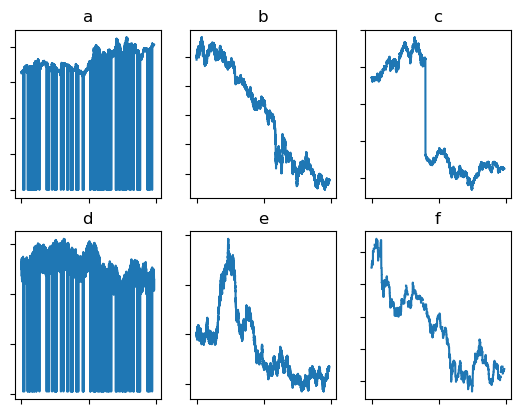

In [3]:
### for convenience and to keep this cell compact
def wrap_plot_info(df, axis, x,y, label):
    axis[x, y].plot(df[label])
    axis[x, y].set_title(label)
    axis[x,y].xaxis.set_ticklabels([])
    axis[x,y].yaxis.set_ticklabels([])
    return

def plot_all(df, func):
    figure, axis = plt.subplots(2, 3)
    func(df, axis, 0, 0, 'a')
    func(df, axis, 0, 1, 'b')
    func(df, axis, 0, 2, 'c')
    func(df, axis, 1, 0, 'd')
    func(df, axis, 1, 1, 'e')
    func(df, axis, 1, 2, 'f')
    plt.show()
    return

plot_all(data, wrap_plot_info)
### Looks like 'a' and 'd' have some missing values. There are some additional discontinuities 'c' and 'f'

## 0.2 Data Hygiene

#### It looks like there are some issues with the data. There are are a significant number of NaNs as well as discontinuities.

#### Let's start with the timestamps



In [4]:
### While we are at it let's just check the timestamps
base = datetime.datetime(2020,1,1,0,0,0)

def combine_day_and_time(row):
    day = row['day']
    time = row['timestr'].split(':')
    delta = datetime.timedelta(days = int(day), hours = int(time[0]), minutes = int(time[1]))
    return base + delta
    
data['timestamp'] = data.apply(combine_day_and_time, axis = 1)
data = data.set_index(pd.DatetimeIndex(data['timestamp']))


diffs = np.diff(data['timestamp'])
jumps = np.unique(diffs, return_counts = True)
time_jumps_in_hours = jumps[0]/(60*jumps[0][0])
num_jumps = jumps[1] # For legibility

data = data.drop(['timestamp', 'timestr'], axis = 1)

time_steps = dict(zip(time_jumps_in_hours, num_jumps))
time_steps
### So it looks like there are some gaps in the timestamps.

{0.016666666666666666: 98100, 17.5: 199, 41.5: 1, 65.5: 43, 68.5: 1, 89.5: 7}

#### So thinking about these timestamps:
There are the one minute intervals (each day for 6.5 hours), 
then 199 weeknights (17.5 hours), 
1 midweek holiday (24 + 17.5 = 41.5), 
weekends (48 + 17.5 = 65.5), 
and 7 three-day weekends (72 + 17.5 = 89.5). 
It looks like there is also one half-day in there (68.5), which I am going to ignore.

In [5]:
"""
There are significant NaNs in 'a', 'c', 'd' and 'e.'

Taking a look at some of the gaps in 'a' and 'd,'
it is determined that they default at the same places.
That tells me that actually column 'd' might actually be the vol or variance of 'a', 
not an equity in and of itself. We will look at that in more detail
(scratch work suppressed)
"""
data.loc[(data['d'] == 1) & (data['a'] == 0)]
### as a result of this, I won't be parameter selecting based on the results from 'a' and 'd'

,day,a,b,c,d,e,f
timestamp,,,,,,,
2020-01-05 10:11:00,4,0.0,14.575,94.405,1.0,50.92,17.995
2020-01-09 11:04:00,8,0.0,14.275,93.015,1.0,48.84,NaN
2020-01-18 15:41:00,17,0.0,14.435,95.275,1.0,49.95,17.975
2020-01-19 09:35:00,18,0.0,14.085,94.120,1.0,49.16,17.975
2020-01-23 11:51:00,22,0.0,14.005,94.280,1.0,49.11,17.905
...,...,...,...,...,...,...,...
2020-12-11 12:30:00,345,0.0,5.545,46.325,1.0,40.80,10.815
2020-12-13 11:00:00,347,0.0,5.305,43.888,1.0,38.86,10.245
2020-12-14 11:20:00,348,0.0,5.265,44.337,1.0,39.64,10.385


#### Later, we are going to return to this hypothesis that 'a' and 'd' are related.
#### There is a clear weekly periodicity of 'd'. (Could 'd' be the market volume of 'a'?)

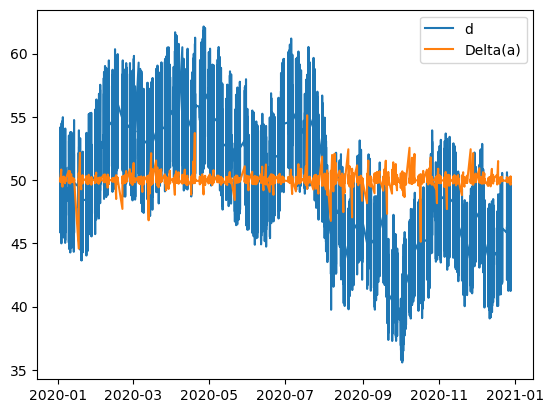

In [6]:
relevant = data[data['a'] > 0]
plt.plot(relevant['d'], label = 'd')
plt.plot(100*relevant['a'].pct_change()+50, label = 'Delta(a)')
plt.legend()

#### I wasn't really able to figure out the relationship between 'a' and 'd.' It is a question to ask the interviewer.

#### There is a huge jump for asset 'c' between May 25 and May 29. I am going to discard all the 'c' data before May 25 because it is clearly seasonal data I will set the values before May 25 to be the mean of week of May29 (scratchwork suppressed)

In [7]:
c_mu = data.loc['2020-05-29 09:30:00':'2020-06-02 16:00:00', 'c'].mean()
data.loc[:'2020-05-25 16:00:00','c'] = c_mu

#### Okay so let's get this cleaned up. In the interest of time and space, I am just going to use time-interpolation on the NaNs

In [8]:
SERIES_COLS = ['a','b','c','d','e','f']

data['a'].replace(0.0, np.NaN, inplace = True)
data['d'].replace(1.0, np.NaN, inplace = True)
### Now I will just time-interpolate over NaNs.
data[SERIES_COLS] = data[SERIES_COLS]\
    .interpolate(method ='time', axis = 0).convert_dtypes()

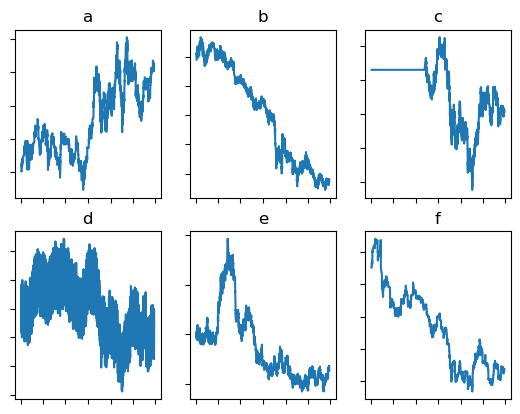

In [9]:
### Let's take another look

plot_all(data, wrap_plot_info)

## 0.3 Computing volatility metrics

#### Before doing any prediction we will look at several measures of volatility.
#### This depends pretty heavily on what we mean by volatility. We will look at a number of metrics, and assess their suitability for modeling
- End of day raw returns
- Intraday range
- minute-by-minute returns
- minute-by-minute percent returns
- historical volatility over various time periods

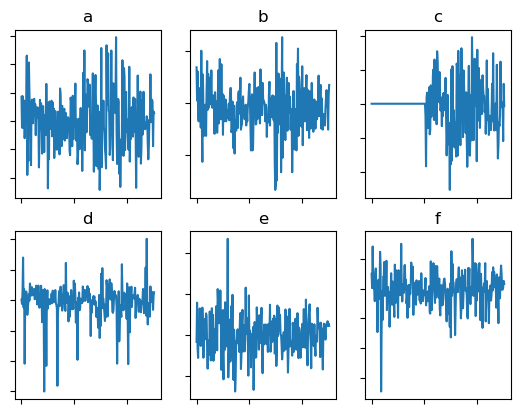

In [10]:
### First, let's look at EOD raw returns

def daily_change(df):
    x = df[SERIES_COLS].to_numpy().astype(np.float64)
    change = x[-1]-x[0]
    return change

daily_change = pd.DataFrame(data.groupby('day').apply(daily_change).to_list(),
                            columns = SERIES_COLS)

plot_all(daily_change, wrap_plot_info)

In [11]:
### To help set a baseline, and make sure our units are comensurate, 
### we will keep track of the mean of these signals in the last month.

daily_change_baseline = np.sqrt(252*np.power(daily_change, 2).loc[-21:,].mean())
daily_change_baseline

a    77.841485
b     3.674748
c    10.631564
d    17.912154
e    15.295545
f     4.773804
dtype: float64

In [12]:
### Let's check the autocorrelation of these signals
### Keep in mind that we will only use 'b', 'e' and 'f' for parameter selection.

LAG_IN_DAYS = 42 # two month's worth

daily_change_autocorr = pd.DataFrame(data = [[daily_change[col].autocorr(lag = i)\
                                              for col in daily_change.columns]\
                                              for i in range(LAG_IN_DAYS)], 
                                     index = range(LAG_IN_DAYS),
                                     columns = daily_change.columns)

daily_change_autocorr
;

''

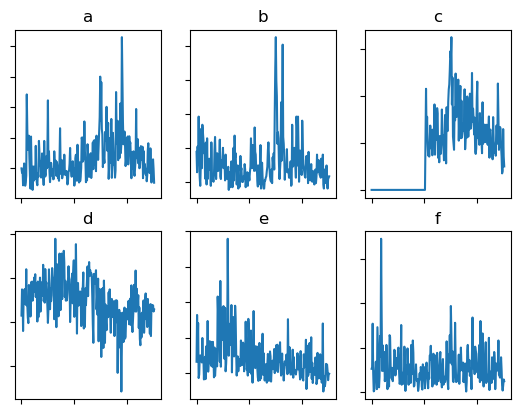

In [13]:
# Let's compare this to the intraday range
def intraday_range(df):
    M = df[SERIES_COLS].max()
    m = df[SERIES_COLS].min()
    return M - m

intraday_range = data.groupby('day').apply(intraday_range).reset_index()

plot_all(intraday_range, wrap_plot_info)

In [14]:
### Let's check the autocorrelation of these signals
### Keep in mind that we will only use 'b', 'e' and 'f' for parameter selection.

intraday_range_autocorr = pd.DataFrame(data = [[intraday_range[col].autocorr(lag = i)\
                                              for col in intraday_range.columns]\
                                              for i in range(LAG_IN_DAYS)], 
                                              index = range(LAG_IN_DAYS),
                                              columns = intraday_range.columns)

daily_change_autocorr
;

''

In [15]:
intraday_range_baseline = np.sqrt(252*np.power(intraday_range[SERIES_COLS], 2).loc[-21:,].mean())
intraday_range_baseline

a    119.808331
b      6.582741
c     17.508978
d    143.271463
e     24.219870
f      5.430893
dtype: float64

#### We will attempt to model this in the next section

#### So now let's look at instantaneous (raw) return.

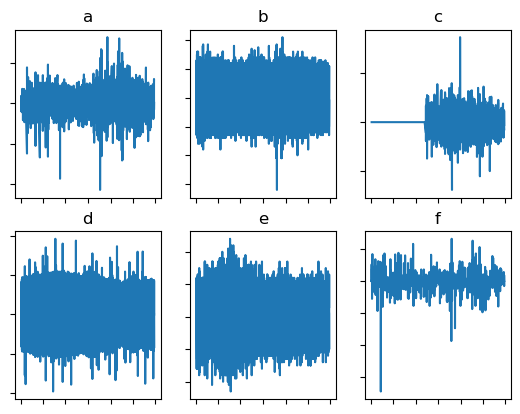

In [16]:
insta_raw = data.diff()
insta_raw = insta_raw[insta_raw['day'] == 0] # We are only interested in intraday changes.
plot_all(insta_raw, wrap_plot_info)

In [17]:
month = insta_raw.index.size//12
insta_raw_baseline = np.sqrt(390*252*np.power(insta_raw[SERIES_COLS],2).reset_index().loc[-month:,].mean())
insta_raw_baseline

C:\Users\ddott\AppData\Local\Temp\ipykernel_42452\624160611.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  insta_raw_baseline = np.sqrt(390*252*np.power(insta_raw[SERIES_COLS],2).reset_index().loc[-month:,].mean())


a     77.350075
b     22.433862
c     12.116028
d    283.751310
e     14.240179
f      4.652776
dtype: float64

#### Now let's take a look at (raw) percent change

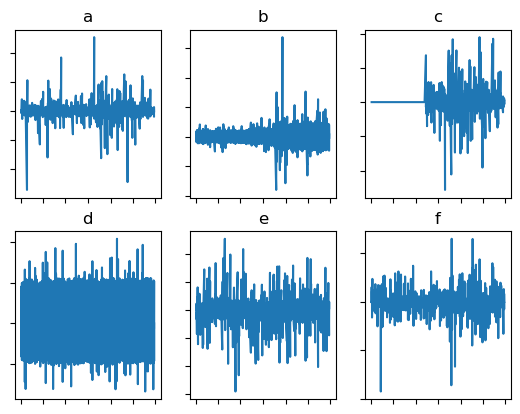

In [18]:
insta_pct_change = data[SERIES_COLS].pct_change().fillna(0.0).astype(np.float64)
plot_all(insta_pct_change, wrap_plot_info)

In [19]:
### Let's look at the autocorrelation

LAG_IN_MINS = 390 #One day

insta_pct_change_autocorr = pd.DataFrame(data = [[insta_pct_change[col].autocorr(lag = i)\
                                                  for col in insta_pct_change.columns]\
                                                  for i in range(LAG_IN_MINS)], 
                                         index = range(LAG_IN_MINS),
                                         columns = insta_pct_change.columns)

insta_pct_change_autocorr.loc[1:,]

;

''

In [20]:
month = 8190
base = data.reset_index()[SERIES_COLS].loc[-month:,].mean() #Just to get the baseline in the same units.
raw_pct_baseline = np.sqrt(252*390*np.power(insta_pct_change.reset_index()[SERIES_COLS].loc[-month:,],2).mean())*base
raw_pct_baseline

a     99.206747
b     27.267256
c     17.241997
d    284.368826
e     15.644022
f      4.809581
dtype: float64


#### Now let's look at historical vol (simple moving average) over different periods. Note that these signals (by design) have strong autocorrelation.

In [21]:
"""
Here let's look at historical vol over different time periods of different lengths
"""
### historical vol of raw returns
def vol_col(column_name, window_in_minutes):
    delta = datetime.timedelta(minutes = window_in_minutes)
    series = data[column_name].diff().rolling(window = delta, min_periods = 3).std(ddof=1).fillna(0.0)
    #root_scale = np.sqrt(TRADING_MINUTES_PER_YEAR/window_in_minutes)
    return series

scales = [10080, 43920] # We look at volatility at scales "day", "week" and "month"

vol_data = pd.DataFrame()
for col in SERIES_COLS:
    for scale in scales:
        ticks = scale*1950//10080
        vol_data[col + "_" + str(scale)] = vol_col(col, scale)[ticks:]

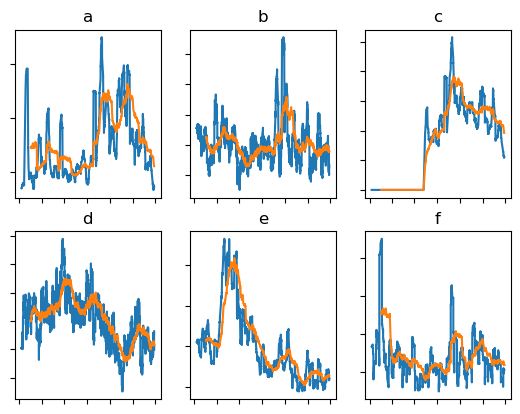

In [22]:
### Let's eyeball this vol data
def wrap_vol_plot_info(df, axis, x,y, col):
    for scale in scales:
        axis[x, y].plot(df[col + '_' + str(scale)])
    axis[x, y].set_title(col)
    axis[x,y].xaxis.set_ticklabels([])
    axis[x,y].yaxis.set_ticklabels([])
    return

plot_all(vol_data, wrap_vol_plot_info)

In [23]:
month = vol_data.index.size//12
vol_data_baseline = np.sqrt(390*252)*vol_data.reset_index().loc[-month:,].mean()
vol_data_baseline

C:\Users\ddott\AppData\Local\Temp\ipykernel_42452\226944202.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  vol_data_baseline = np.sqrt(390*252)*vol_data.reset_index().loc[-month:,].mean()


a_10080     94.350473
a_43920     99.332798
b_10080     22.597379
b_43920     22.599188
c_10080     12.128126
c_43920     12.967507
d_10080    283.496753
d_43920    284.692445
e_10080     15.685358
e_43920     15.838356
f_10080      4.301743
f_43920      4.482361
dtype: float64

In [24]:
### historical vol of raw returns
def ewmaf(column_name, alpha):
    series = np.sqrt(np.power(data[column_name].diff(),2).ewm(alpha = alpha).mean().to_numpy())[1950:] #Ditching the first week
    return series

alphas = [0.0005, 0.0001, 0.00005] # Super tiny alphas because we want very smooth signals to try to predict.

ewma_data = pd.DataFrame()
for col in SERIES_COLS:
    for alpha in alphas:
        ewma_data[col + "_" + str(alpha)] = ewmaf(col, alpha)
        
ewma_data

,a_0.0005,a_0.0001,a_5e-05,b_0.0005,b_0.0001,b_5e-05,c_0.0005,c_0.0001,c_5e-05,d_0.0005,d_0.0001,d_5e-05,e_0.0005,e_0.0001,e_5e-05,f_0.0005,f_0.0001,f_5e-05
0,0.136412,0.139723,0.140152,0.073186,0.073114,0.073106,0.000000,0.000000,0.000000,0.837460,0.809097,0.805518,0.051314,0.051080,0.051046,0.015749,0.016472,0.016547
1,0.136364,0.139688,0.140118,0.073223,0.073140,0.073131,0.000000,0.000000,0.000000,0.837125,0.808869,0.805301,0.051305,0.051074,0.051041,0.015743,0.016467,0.016542
2,0.136312,0.139651,0.140082,0.073194,0.073120,0.073112,0.000000,0.000000,0.000000,0.840950,0.811670,0.807986,0.051286,0.051061,0.051028,0.015737,0.016463,0.016538
3,0.136281,0.139628,0.140060,0.073166,0.073100,0.073092,0.000000,0.000000,0.000000,0.844726,0.814437,0.810639,0.051272,0.051051,0.051019,0.015730,0.016458,0.016533
4,0.136247,0.139603,0.140036,0.073181,0.073110,0.073103,0.000000,0.000000,0.000000,0.844387,0.814208,0.810421,0.051252,0.051037,0.051006,0.015724,0.016454,0.016529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96397,0.173936,0.292015,0.331822,0.071231,0.071630,0.071873,0.035126,0.054413,0.059368,0.814095,0.829597,0.846952,0.042376,0.042737,0.044233,0.009844,0.012566,0.013519
96398,0.173893,0.292001,0.331814,0.071248,0.071633,0.071875,0.035118,0.054411,0.059367,0.813965,0.829570,0.846938,0.042375,0.042736,0.044232,0.009842,0.012566,0.013518
96399,0.173864,0.291988,0.331806,0.071231,0.071630,0.071873,0.035110,0.054408,0.059366,0.813762,0.829528,0.846916,0.042367,0.042735,0.044232,0.009842,0.012565,0.013518
96400,0.173825,0.291974,0.331798,0.071213,0.071626,0.071872,0.035104,0.054406,0.059364,0.813558,0.829487,0.846895,0.042357,0.042733,0.044231,0.009839,0.012565,0.013518


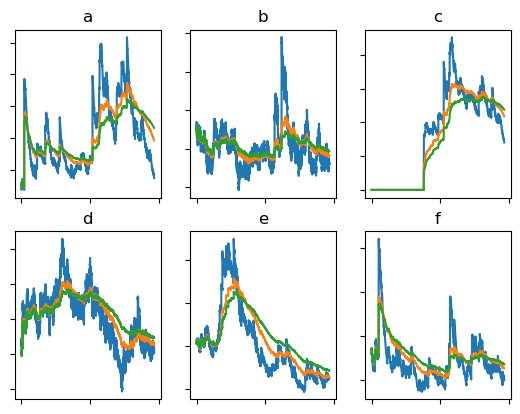

In [25]:
### Let's eyeball this vol data
def wrap_ewma_plot_info(df, axis, x,y, col):
    for alpha in alphas:
        axis[x, y].plot(df[col + '_' + str(alpha)])
    axis[x, y].set_title(col)
    axis[x,y].xaxis.set_ticklabels([])
    axis[x,y].yaxis.set_ticklabels([])
    return

plot_all(ewma_data, wrap_ewma_plot_info)

In [26]:
month = vol_data.index.size//12
ewma_data_baseline = np.sqrt(390*252)*ewma_data.reset_index().loc[-month:,].mean()
ewma_data_baseline

index       1.511068e+07
a_0.0005    9.610530e+01
a_0.0001    9.762409e+01
a_5e-05     9.547123e+01
b_0.0005    2.259515e+01
b_0.0001    2.261375e+01
b_5e-05     2.261569e+01
c_0.0005    1.214100e+01
c_0.0001    1.144330e+01
c_5e-05     1.043311e+01
d_0.0005    2.837993e+02
d_0.0001    2.859096e+02
d_5e-05     2.880749e+02
e_0.0005    1.572954e+01
e_0.0001    1.604862e+01
e_5e-05     1.636868e+01
f_0.0005    4.445104e+00
f_0.0001    4.767191e+00
f_5e-05     4.911858e+00
dtype: float64

In [27]:
### Let's collect these baselines together

hist_vol = vol_data_baseline[[(col + '_10080') for col in SERIES_COLS]].to_list()
ewma_base = ewma_data_baseline[[(col + '_0.0005') for col in SERIES_COLS]].to_list()

baselines = pd.DataFrame(data = [daily_change_baseline.to_list(),
                                 intraday_range_baseline.to_list(),
                                 insta_raw_baseline.to_list(),
                                 raw_pct_baseline.to_list(),
                                 hist_vol,
                                 ewma_base,
                         ],
                         index = range(6),
                         columns = SERIES_COLS)

baselines

,a,b,c,d,e,f
0,77.841485,3.674748,10.631564,17.912154,15.295545,4.773804
1,119.808331,6.582741,17.508978,143.271463,24.219870,5.430893
2,77.350075,22.433862,12.116028,283.751310,14.240179,4.652776
3,99.206747,27.267256,17.241997,284.368826,15.644022,4.809581
4,94.350473,22.597379,12.128126,283.496753,15.685358,4.301743
5,96.105303,22.595148,12.141000,283.799310,15.729539,4.445104


In [28]:
def avg_baseline(series):
    # Drop the max and min and average the rest.
    M = series.max()
    m = series.min()
    return (series.sum() - M - m)/(series.size - 2)

baselines.apply(avg_baseline, axis = 0)

a     91.876002
b     18.552283
c     13.406788
d    248.579709
e     15.588616
f      4.670316
dtype: float64

## 1.1 Fit some GARCH models
#### The level zero play is to see how GARCH models do. Because we are forecasting an entire month, I do not have high hopes.

In [29]:
FORECAST_IN_DAYS = 21 #One month (in days)

time_series = daily_change.reset_index()[['a','b','c','d','e','f']].astype(np.float64)

validate = {}
for col in time_series.columns:
    model = arch_model(time_series.loc[:time_series.index.size-FORECAST_IN_DAYS,col], 
                       mean='Constant', # assuming a constant mean for the diff process
                       vol='GARCH', 
                       p=5, # I am going to ignore explicit autoregression of the innovation beyond 1 week.
                       q=21, # I am forecasting out 21 days, so I am going to overfit to make sure I get the monthly dynamics.
                       rescale = True) 
    info = {}
    info["model"] = model
    res = model.fit()
    info['fit'] = res
    forecast = res.forecast(method = 'analytic', horizon=FORECAST_IN_DAYS)
    var_forecast = forecast.variance.values[0]
    mu_forecast = forecast.mean
    info["var_forecast"] = forecast.variance.values[0]#
    info["forecast_mean"] = forecast.mean.values[0]
    info["testdata"] = time_series.loc[time_series.index.size-FORECAST_IN_DAYS:,col].to_numpy()
    info["var_testdata"] = (time_series.rolling(window = 21).var()).loc[time_series.index.size-FORECAST_IN_DAYS:,col].to_numpy()
    validate[col] = info
    
;

Iteration:      1,   Func. Count:     30,   Neg. LLF: 809.4834148642864
Iteration:      2,   Func. Count:     60,   Neg. LLF: 735.0188527850785
Iteration:      3,   Func. Count:     90,   Neg. LLF: 702.5679974191931
Iteration:      4,   Func. Count:    120,   Neg. LLF: 697.9994021853491
Iteration:      5,   Func. Count:    150,   Neg. LLF: 728.8360280050313
Iteration:      6,   Func. Count:    180,   Neg. LLF: 697.980403493601
Iteration:      7,   Func. Count:    210,   Neg. LLF: 696.4028345035547
Iteration:      8,   Func. Count:    240,   Neg. LLF: 695.5677703862823
Iteration:      9,   Func. Count:    269,   Neg. LLF: 695.8614359377184
Iteration:     10,   Func. Count:    299,   Neg. LLF: 746.4074211440524
Iteration:     11,   Func. Count:    330,   Neg. LLF: 695.7734418778318
Iteration:     12,   Func. Count:    360,   Neg. LLF: 695.2855027050791
Iteration:     13,   Func. Count:    390,   Neg. LLF: 695.2774611649671
Iteration:     14,   Func. Count:    420,   Neg. LLF: 695.2526758

Iteration:     14,   Func. Count:    419,   Neg. LLF: 314.0146907806436
Iteration:     15,   Func. Count:    449,   Neg. LLF: 313.11362375871755
Iteration:     16,   Func. Count:    479,   Neg. LLF: 312.9391768469317
Iteration:     17,   Func. Count:    508,   Neg. LLF: 312.9197552019566
Iteration:     18,   Func. Count:    537,   Neg. LLF: 312.9159280215482
Iteration:     19,   Func. Count:    566,   Neg. LLF: 312.91549883405594
Iteration:     20,   Func. Count:    595,   Neg. LLF: 312.9151091025926
Iteration:     21,   Func. Count:    624,   Neg. LLF: 312.91495218136026
Iteration:     22,   Func. Count:    653,   Neg. LLF: 312.9149279833962
Iteration:     23,   Func. Count:    682,   Neg. LLF: 312.91491412701913
Iteration:     24,   Func. Count:    711,   Neg. LLF: 312.9149133740759
Optimization terminated successfully    (Exit mode 0)
            Current function value: 312.9149133740759
            Iterations: 24
            Function evaluations: 711
            Gradient evaluation

''

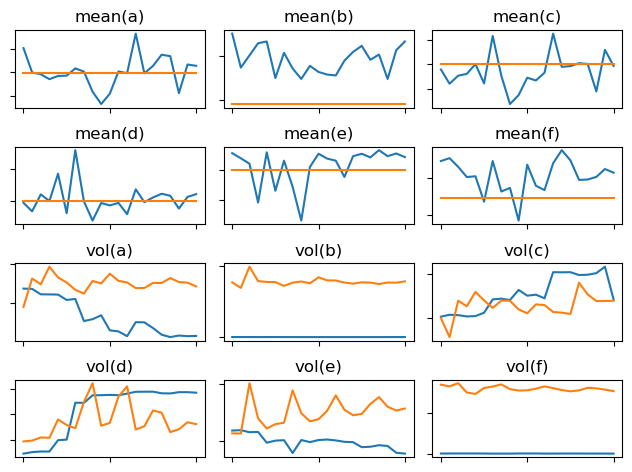

In [30]:
### Let's eyeball this vol data
def wrap_predict_plot_info(axis, x,y, col):
    axis[x, y].plot(validate[col]['testdata'], label = "True")
    axis[x, y].plot(validate[col]['forecast_mean'], label = "Forecast")
    axis[x, y].set_title("mean(" + col + ")")
    axis[x, y].xaxis.set_ticklabels([])
    axis[x, y].yaxis.set_ticklabels([])
    axis[x+2, y].plot(validate[col]['var_testdata'], label = "True")
    axis[x+2, y].plot(validate[col]['var_forecast'], label = "Forecast")
    axis[x+2, y].set_title("vol(" + col + ")")
    axis[x+2, y].xaxis.set_ticklabels([])
    axis[x+2, y].yaxis.set_ticklabels([])
    return

def plot_garch():
    figure, axis = plt.subplots(4, 3)
    wrap_predict_plot_info(axis, 0, 0, 'a')
    wrap_predict_plot_info(axis, 0, 1, 'b')
    wrap_predict_plot_info(axis, 0, 2, 'c')
    wrap_predict_plot_info(axis, 1, 0, 'd')
    wrap_predict_plot_info(axis, 1, 1, 'e')
    wrap_predict_plot_info(axis, 1, 2, 'f')
    figure.tight_layout(pad = 1.0)
    plt.show()
    
plot_garch()

#### We can see that the GARCH model does a decent job modeling the signals that I am NOT using for parameter selection (I am using b,e,f for parameter selection; see above). Furthermore, the autocorrelation analysis indicates that I should be able to get a fit for much smaller values of p,q. Therefore I think these model are overfitting. 

#### We include the models for the 1-minute sampling series for reference. However, having a recursive model forecast over 8000 ticks into the future is going to lead to highly unstable results.

In [31]:
FORECAST_IN_MINUTES = 8190 #One month (in minutes)

## the arch library has a known bug with python indexing. Just circumventing the bug even though not pythonic.
l = insta_pct_change.index.size 
train = l - FORECAST_IN_MINUTES
time_series = insta_pct_change.reset_index()[['a','b','c','d','e','f']].astype(np.float64)

validate = {}
for col in time_series.columns:
    model = arch_model(time_series.loc[:train,col], 
                       mean='ARX',
                       vol='GARCH', 
                       p=5, # We spent quite a lot of time training for much higher orders of p and q with no sensible results.
                       q=5,
                       rescale = True) 
    info = {}
    info["model"] = model
    res = model.fit()
    info['fit'] = res
    forecast = res.forecast(method = 'analytic', horizon=FORECAST_IN_MINUTES)
    var_forecast = forecast.variance.values[0]
    mu_forecast = forecast.mean
    info["var_forecast"] = forecast.variance.values[0]
    info["forecast_mean"] = forecast.mean.values[0]
    info["testdata"] = time_series.loc[train:,col].to_numpy()
    info["var_testdata"] = time_series.rolling(window = 390).var().loc[train:,col].to_numpy()*np.sqrt(8190)
    validate[col] = info
    
;

Iteration:      1,   Func. Count:     14,   Neg. LLF: 910150.2101239554
Iteration:      2,   Func. Count:     33,   Neg. LLF: 184335.87750898214
Iteration:      3,   Func. Count:     49,   Neg. LLF: 207874.53530598123
Iteration:      4,   Func. Count:     63,   Neg. LLF: 113527.00751896825
Iteration:      5,   Func. Count:     77,   Neg. LLF: 110519.78284849555
Iteration:      6,   Func. Count:     91,   Neg. LLF: 109487.77142247956
Iteration:      7,   Func. Count:    105,   Neg. LLF: 187610.14830456392
Iteration:      8,   Func. Count:    119,   Neg. LLF: 133073.06477950557
Iteration:      9,   Func. Count:    133,   Neg. LLF: 113503.68588009548
Iteration:     10,   Func. Count:    147,   Neg. LLF: 107241.56583874807
Iteration:     11,   Func. Count:    161,   Neg. LLF: 107727.64027263198
Iteration:     12,   Func. Count:    175,   Neg. LLF: 106629.29480608343
Iteration:     13,   Func. Count:    189,   Neg. LLF: 106123.29104058316
Iteration:     14,   Func. Count:    202,   Neg. LLF

C:\Users\ddott\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 1060312.6692320574
Iteration:      2,   Func. Count:     32,   Neg. LLF: 19791887.96901978
Iteration:      3,   Func. Count:     50,   Neg. LLF: 193774.30542457642
Iteration:      4,   Func. Count:     66,   Neg. LLF: 420461364849778.94
Iteration:      5,   Func. Count:     84,   Neg. LLF: 53519271168.822815
Iteration:      6,   Func. Count:    100,   Neg. LLF: 211813.11224611636
Iteration:      7,   Func. Count:    115,   Neg. LLF: 213260.70792484976
Iteration:      8,   Func. Count:    131,   Neg. LLF: 237821.5520963072
Iteration:      9,   Func. Count:    147,   Neg. LLF: 100182.7551264102
Iteration:     10,   Func. Count:    161,   Neg. LLF: 100343.99193913875
Iteration:     11,   Func. Count:    175,   Neg. LLF: 99483.85002564812
Iteration:     12,   Func. Count:    189,   Neg. LLF: 8.211007429857136e+16
Iteration:     13,   Func. Count:    208,   Neg. LLF: 47182566638.14975
Iteration:     14,   Func. Count:    224,   Neg. LLF:

C:\Users\ddott\anaconda3\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:     14,   Neg. LLF: 255306.93014558664
Iteration:      2,   Func. Count:     29,   Neg. LLF: 337265.68895578594
Iteration:      3,   Func. Count:     44,   Neg. LLF: 895989.4160747196
Iteration:      4,   Func. Count:     58,   Neg. LLF: 168085.24862752852
Iteration:      5,   Func. Count:     73,   Neg. LLF: 317087.02247691085
Iteration:      6,   Func. Count:     87,   Neg. LLF: 159146.77641695598
Iteration:      7,   Func. Count:    100,   Neg. LLF: 159117.64297754355
Iteration:      8,   Func. Count:    113,   Neg. LLF: 168946.56649741964
Iteration:      9,   Func. Count:    128,   Neg. LLF: 1716763.4419812933
Iteration:     10,   Func. Count:    144,   Neg. LLF: 167576.66477914387
Iteration:     11,   Func. Count:    158,   Neg. LLF: 160039.7784110743
Iteration:     12,   Func. Count:    172,   Neg. LLF: 159130.29683614595
Iteration:     13,   Func. Count:    186,   Neg. LLF: 193288.9663611776
Iteration:     14,   Func. Count:    201,   Neg. LLF: 

''

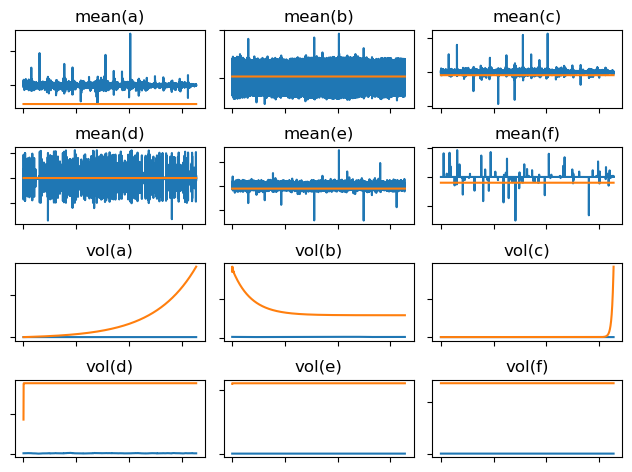

In [32]:
plot_garch()

#### So the GARCH models definitely fail to forecast 8000 ticks into the future--even with considerable parameter tuning. I won't show you the same results for raw instantaneous returns

#### Just to drive this point home, let us attempt to continue the exponentially weighted moving average recursively. We will get the unstable results.

In [33]:
### historical vol of raw returns

HORIZON = 21
ALPHA = 0.04

def weight(alpha, t):
    if (np.power(1e-300, 1/t) > 1-alpha):
        return 0
    else:
        val = (1 - np.power(1-alpha, t))/(1-alpha)
        if np.isnan(val):
            return 0.0
        else:
            return val

def cont_ewm(series, horizon, alpha):
    # Assuming the series is already a exponentially weighted moving average
    sz = series.size
    forecast = np.repeat(0, horizon)
    forecast[0] = ((1 + weight(alpha, horizon - 1)*(1-alpha))*series[-1])/(weight(alpha, horizon))
    for t in range(1,horizon):
        previous = forecast[t-1]
        N = series.size + t
        w_N = weight(alpha, N)
        w_N_1 = weight(alpha, N-1)
        if w_N == 0:
            print('FAIL')
            return 0
        forecast[t] = ((1 + w_N_1*(1-alpha))*previous)/w_N
    return np.concatenate((series, forecast))
        
ewm_predictor = pd.DataFrame()
for col in SERIES_COLS:
    sz = intraday_range.index.size
    series = np.power(intraday_range[col],2).ewm(alpha = ALPHA).mean().to_numpy()
    #clip = series[series.size - USE:]
    ewm_predictor[col + "_true"] = series
    ewm_predictor[col + "_hat"] = cont_ewm(series[:-HORIZON], HORIZON, ALPHA)

ewm_predictor

,a_true,a_hat,b_true,b_hat,c_true,c_hat,d_true,d_hat,e_true,e_hat,f_true,f_hat
0,24.552025,2.455202e+01,0.220900,0.220900,0.000000,0.0,68.939809,6.893981e+01,1.742400,1.742400e+00,0.067600,0.067600
1,21.219372,2.121937e+01,0.160441,0.160441,0.000000,0.0,79.754211,7.975421e+01,4.409339,4.409339e+00,0.073110,0.073110
2,21.619680,2.161968e+01,0.195025,0.195025,0.000000,0.0,82.812480,8.281248e+01,3.870319,3.870319e+00,0.253493,0.253493
3,17.135467,1.713547e+01,0.185726,0.185726,0.000000,0.0,76.152725,7.615273e+01,4.384819,4.384819e+00,0.199038,0.199038
4,17.373228,1.737323e+01,0.260942,0.260942,0.000000,0.0,77.339657,7.733966e+01,3.595073,3.595073e+00,0.155921,0.155921
...,...,...,...,...,...,...,...,...,...,...,...,...
247,50.471416,6.259707e+06,0.124253,0.000000,1.538712,114050.0,70.581434,6.197083e+06,1.394129,7.933700e+04,0.094853,0.000000
248,49.777334,1.201887e+07,0.120882,0.000000,1.483723,218980.0,70.656345,1.189863e+07,1.383307,1.523290e+05,0.091066,0.000000
249,49.442597,2.307665e+07,0.118963,0.000000,1.491455,420449.0,70.905213,2.284579e+07,1.353574,2.924770e+05,0.087620,0.000000
250,48.405757,4.430796e+07,0.117340,0.000000,1.451846,807276.0,70.949494,4.386469e+07,1.335530,5.615650e+05,0.084899,0.000000


#### You can see that the predictors are highly unstable.

## 1.3 Trigonometric Regression

#### As opposed to doing linear or polynomial regression, I am going to observe the periodic nature of the signals and give a regression by trigonometric functions.

#### *Implicit in this approach is the assumption that vol has an inherently periodic signal. This is not that far from similar assumptions in GARCH*

#### We will regress on the exponentially weighted moving averages, which are a bit smoother.

#### One innovation: a trigonometric approximation is usually going to have high Dirichlet energy near the endpoints of the interval. To deal with that, we will apply a smoothing:

#### Let P_k be the projection operator onto degree-k trigonometric series. We will use the operator Q_k defined as, Q_k(f) = (1/cosh(x))P_k(cosh(x)f). This will give us an approximator which is smoother at the boundary. *Note that multiplying by cosh will increase the amplitude of high frequency components, so this method will work best on smoother inputs*

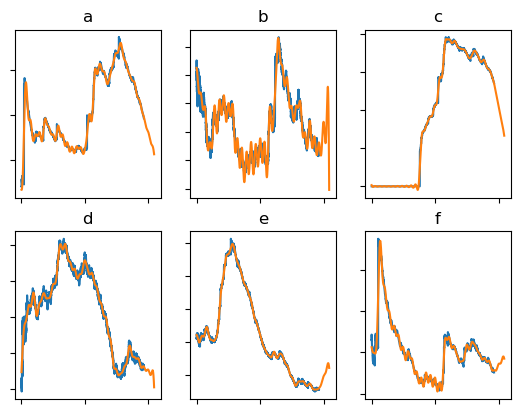

In [34]:
### As opposed to doing linear or polynomial regression,
### I am going to observe the periodic nature of the signals
### and give a regression by trigonometric functions.
DEGREE = 32

def approx_by_trig(series, degree, buffer, exp_param = 3):
    space = series.to_numpy()
    endsize = (space[0] + space[-1])/2
    leftend = np.linspace(endsize, space[0], buffer)
    rightend = np.linspace(space[-1], endsize, buffer)
    buffered_space = np.concatenate((leftend, space, rightend))
    factor = np.cosh(np.linspace(-exp_param, exp_param, num = buffered_space.size))
    coshed = buffered_space*factor
    phase = np.fft.rfft(coshed)
    phase[degree:] = 0.0
    respace = np.fft.irfft(phase)/factor
    return respace[buffer:]

def wrap_ewma_approx_info(df, axis, x,y, col):
    axis[x,y].plot(df[col + "_0.0001"])
    buffer = df.index.size//12
    axis[x,y].plot(approx_by_trig(df[col + "_0.0001"], DEGREE, buffer))
    axis[x, y].set_title(col)
    axis[x,y].xaxis.set_ticklabels([])
    axis[x,y].yaxis.set_ticklabels([])
    return

plot_all(ewma_data, wrap_ewma_approx_info)

In [35]:
def compare_approx(col_name, degree):
    series = ewma_data[col_name]
    buffer = series.index.size//12
    approx = approx_by_trig(series, degree, buffer)[:-buffer]
    real = series.to_numpy()
    return np.sqrt(np.sum(np.power(real - approx, 2)))

MAX_DEGREE = 32
trig_approx_errors = pd.DataFrame(data = [[compare_approx(col, deg)\
                                          for col in ewma_data.columns]\
                                          for deg in range(1,MAX_DEGREE)], 
                                          index = range(1,MAX_DEGREE),
                                          columns = ewma_data.columns)

trig_approx_errors

,a_0.0005,a_0.0001,a_5e-05,b_0.0005,b_0.0001,b_5e-05,c_0.0005,c_0.0001,c_5e-05,d_0.0005,d_0.0001,d_5e-05,e_0.0005,e_0.0001,e_5e-05,f_0.0005,f_0.0001,f_5e-05
1,90.811392,111.776634,116.342221,28.337804,28.455803,28.500698,11.700767,14.465149,15.086071,326.608954,322.096643,325.964111,18.638851,18.068974,18.200775,6.160900,6.708947,6.750864
2,21.128849,18.437041,24.927470,9.237002,9.246967,9.294822,5.501104,6.549892,7.260205,105.848624,102.645015,101.809355,5.095824,5.416210,5.643603,2.287704,1.918011,1.906636
3,20.720895,10.944198,12.110929,4.480518,4.474636,4.466307,4.208594,4.280416,4.541645,46.379928,46.133624,45.930462,3.478981,3.310826,3.214966,1.477368,0.849621,0.766141
4,21.281851,9.475430,9.277266,2.548127,2.551004,2.549008,2.925350,2.786494,2.990935,24.589710,20.935554,22.425893,2.266171,1.876597,1.820021,1.324079,0.579937,0.500325
5,19.244950,10.116744,9.959650,1.647820,1.576775,1.581858,2.569668,1.417691,1.488604,18.027378,15.216675,15.656956,1.446019,0.945419,0.958912,1.186665,0.640359,0.577832
6,20.071770,11.451470,10.906915,1.096593,1.087417,1.083751,2.360900,1.416567,1.341212,19.355121,13.555350,12.883889,0.810576,0.728718,0.732025,1.268525,0.714724,0.634754
7,16.669149,9.217421,9.079302,0.735676,0.760923,0.771117,2.195648,0.925259,0.754333,11.969527,10.329724,10.232957,0.893767,0.666472,0.638492,1.090636,0.590059,0.542253
8,18.742795,10.682355,9.643057,0.641206,0.595953,0.596811,1.903621,0.716116,0.551002,11.285331,8.877964,8.790830,0.741133,0.481902,0.468526,1.168587,0.604003,0.521910
9,17.274025,9.453927,8.534898,0.558117,0.496073,0.487615,1.943534,0.740393,0.563633,11.514429,7.529440,7.356690,0.642165,0.324981,0.315262,1.050541,0.486408,0.416640
10,14.823144,7.911405,7.365480,0.460627,0.397776,0.392294,1.913987,0.711077,0.532407,10.106161,5.912274,5.781438,0.533853,0.220097,0.212783,0.917433,0.402458,0.341804


#### So let's run a test of the predictive power using a holdout set.

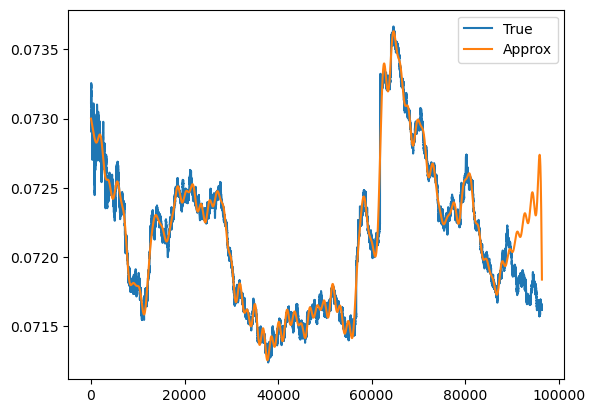

In [36]:
test_forecasts = pd.DataFrame()

def predict_holdout(col, degree, holdout_sz):
    series = ewma_data.loc[:ewma_data.index.size-holdout_sz, col]
    approx = approx_by_trig(series, degree, holdout_sz)
    mse = np.mean(np.power(ewma_data.loc[ewma_data.index.size-holdout_sz:,col].to_numpy() - approx[-holdout_sz:], 2))
    return approx, mse


col = 'b_0.0001'
hsz = ewma_data[col].index.size//12
deg = 64
plt.plot(ewma_data[col], label = "True")
plt.plot(predict_holdout(col, deg, hsz)[0], label = "Approx")
plt.legend()

In [37]:
### FULL TEST
suffix = '_0.0001'
hsz = ewma_data.index.size//12
MAX_DEGREE = 64
trig_holdout_test = pd.DataFrame(data = [[predict_holdout(col+suffix, deg, hsz)[1]\
                                          for col in SERIES_COLS]\
                                          for deg in range(1,MAX_DEGREE)], 
                                          index = range(1,MAX_DEGREE),
                                          columns = SERIES_COLS)

trig_holdout_test

,a,b,c,d,e,f
1,0.043267,1.728197e-03,0.002189,0.224291,0.000507,4.774662e-05
2,0.007771,2.258114e-04,0.000900,0.030927,0.000044,1.215423e-06
3,0.003332,5.724429e-05,0.000504,0.008091,0.000013,7.276290e-07
4,0.002125,2.841846e-05,0.000313,0.003718,0.000013,9.564783e-07
5,0.001710,1.796073e-05,0.000223,0.002551,0.000012,1.718698e-06
...,...,...,...,...,...,...
59,0.000436,2.651935e-07,0.000160,0.000015,0.000008,2.167604e-06
60,0.000435,2.642931e-07,0.000160,0.000015,0.000008,2.169828e-06
61,0.000435,2.635025e-07,0.000160,0.000016,0.000008,2.174842e-06
62,0.000436,2.626923e-07,0.000160,0.000016,0.000008,2.179844e-06


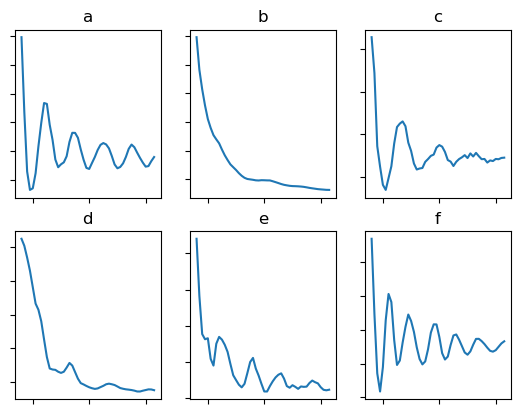

In [38]:
plot_all(trig_holdout_test.loc[16:64,], wrap_plot_info)

In [39]:
def trig_forecast(col, degree, horizon):
    series = ewma_data[col]
    approx = approx_by_trig(series, degree, horizon)
    prior_residuals = series - approx[:series.size]
    return approx[-horizon:], prior_residuals

suffix = '_0.0001'
horizon = ewma_data.index.size//12
DEGREE = 32

trig_results = {}
for col in SERIES_COLS:
    forecast, residuals = trig_forecast(col + suffix, DEGREE, horizon)
    trig_results[col + "_forecast"] = forecast.mean()*np.sqrt(390*252)
    trig_results[col + "_conf_intvl"] = np.quantile(residuals, [0.1, 0.9])
    
trig_results

{'a_forecast': 79.65166840275279,
 'a_conf_intvl': array([-0.00851127,  0.00711689]),
 'b_forecast': 22.57021292549735,
 'b_conf_intvl': array([-0.00018911,  0.00018633]),
 'c_forecast': 12.7915078765676,
 'c_conf_intvl': array([-0.00061574,  0.00063356]),
 'd_forecast': 258.4217864322756,
 'd_conf_intvl': array([-0.0056406 ,  0.00587069]),
 'e_forecast': 14.050484000732292,
 'e_conf_intvl': array([-0.00026665,  0.00024907]),
 'f_forecast': 4.2489864245650155,
 'f_conf_intvl': array([-0.00052425,  0.00051672])}

#### This is VERY comparable to our baseline, so that is a great sign.

## 1.4 Fitting with Hermite polynomials

#### For fun, let's try this with approximation by Hermite polynomials. We will apply the same hyperbolic cos tempering technique.

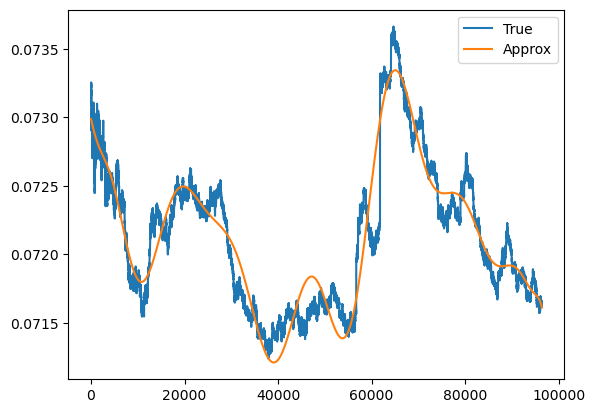

In [40]:
def hermite_approx(series, degree, horizon = 0, exp_param = 3):
    s = series.to_numpy()
    x = np.linspace(-exp_param, exp_param, num = s.size)
    factor = np.cosh(x)
    exp_series = s*factor
    coef = np.polynomial.hermite.hermfit(x, exp_series, degree, full = False )
    delta = 2*horizon*exp_param/s.size
    xh = np.linspace(-exp_param, exp_param + delta, num = s.size + horizon)
    predict = np.polynomial.hermite.hermval(xh, coef)
    extend_factor = np.cosh(xh)
    return predict/extend_factor
    
col = 'b_0.0001'
plt.plot(ewma_data[col], label = "True")
plt.plot(hermite_approx(ewma_data[col], 18), label = "Approx")
plt.legend()

#### Now an out-sample test

In [41]:
suffix = '_0.0001'
s = ewma_data.index.size
hsz = ewma_data.index.size//12
MAX_DEGREE = 64

def hermite_holdout_test(col, deg, horizon):
    true = ewma_data[col + suffix].to_numpy()[s-hsz:]
    approx = hermite_approx(ewma_data.loc[:s-hsz,col + suffix], deg, horizon = hsz)[s-hsz+1:]
    error = np.mean(np.power(true - approx, 2))
    return error
    

hermite_test = pd.DataFrame(data = [[hermite_holdout_test(col, deg, hsz)\
                                     for col in SERIES_COLS]\
                                     for deg in range(1,MAX_DEGREE)], 
                                     index = range(1,MAX_DEGREE),
                                     columns = SERIES_COLS)

hermite_test

C:\Users\ddott\anaconda3\lib\site-packages\numpy\polynomial\hermite.py:1403: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermvander, x, y, deg, rcond, full, w)


,a,b,c,d,e,f
1,4.409842e-02,0.002856,1.044968e-03,3.934739e-01,1.063152e-03,1.116073e-04
2,7.047546e-04,0.000238,2.033341e-04,3.308139e-02,7.659974e-05,1.327401e-06
3,3.771059e-05,0.000248,2.443697e-05,3.342450e-02,8.059810e-05,2.850023e-06
4,3.978290e-04,0.000006,1.878022e-06,7.507713e-04,1.063087e-06,1.443274e-06
5,5.973768e-04,0.000010,1.119041e-05,2.385442e-04,1.017320e-05,7.187791e-06
...,...,...,...,...,...,...
59,9.252238e+09,5646.280771,2.092714e+06,2.441901e+06,1.167064e+07,4.738840e+07
60,4.216596e+09,16677.989131,2.308919e+06,2.109835e+06,7.243859e+06,2.054895e+07
61,5.172545e+09,8744.557295,1.678118e+06,7.815694e+05,6.391111e+06,3.137727e+07
62,2.353920e+09,18767.347884,1.801771e+06,3.049474e+05,3.945950e+06,1.390278e+07


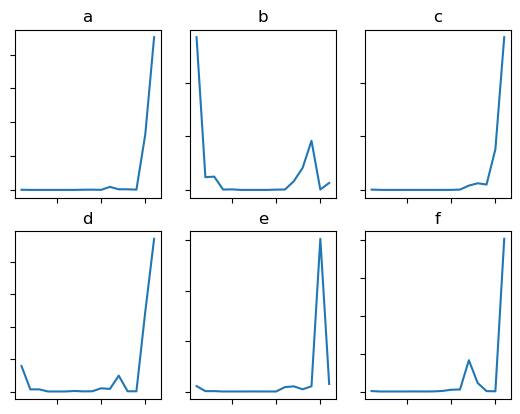

In [42]:
plot_all(hermite_test.loc[:16,], wrap_plot_info)

#### Increasing errors is not a great sign for this technique

In [43]:
def hermite_forecast(col, degree, horizon):
    series = ewma_data[col]
    approx = hermite_approx(series, degree, horizon)
    prior_residuals = series - approx[:series.size]
    return approx[-horizon:], prior_residuals

suffix = '_0.0001'
horizon = ewma_data.index.size//12
DEGREE = 5

hermite_results = {}
for col in SERIES_COLS:
    forecast, residuals = hermite_forecast(col + suffix, DEGREE, horizon)
    hermite_results[col + "_forecast"] = forecast.mean()*np.sqrt(390*252)
    hermite_results[col + "_conf_intvl"] = np.quantile(residuals, [0.1, 0.9])
        
        
hermite_results

{'a_forecast': 84.16491126597023,
 'a_conf_intvl': array([-0.03562366,  0.02801438]),
 'b_forecast': 21.68379130138139,
 'b_conf_intvl': array([-0.00205915,  0.00147648]),
 'c_forecast': 16.952615705336505,
 'c_conf_intvl': array([-0.00439315,  0.00586996]),
 'd_forecast': 258.26904287244935,
 'd_conf_intvl': array([-0.02314526,  0.02375632]),
 'e_forecast': 12.437360521327099,
 'e_conf_intvl': array([-0.00447793,  0.00399251]),
 'f_forecast': 4.475158649607205,
 'f_conf_intvl': array([-0.00330393,  0.0045431 ])}

#### It's in the ballpark anyway.

## 1.5 Regression Tree

#### To get better coverage of approach we will use a non parametric method. Typically, for something like this I might use a random forest variant. However, we don't really have enough data for that to be effective. Also, I am running this on my laptop which is not the best way to train an ensemble model like that.

#### Instead, I will use a tree regressor based on quantile histograms called LightGBM (https://github.com/Microsoft/LightGBM). It is quite fast to train on smaller machines. To do this, I will attempt to have the model predict the sum of squares of the intraday ranges based on the previous intraday ranges.

In [44]:
### Make the training data

# Each training sample will be a month's worth of intraday ranges.
NUM_DAYS = 21

ir_train_data = {}
for col in SERIES_COLS:
    windows = [np.array(window.to_list()) for window in intraday_range[col].rolling(window = NUM_DAYS)]
    ir_train_data[col] = np.array(windows[NUM_DAYS:-NUM_DAYS])
    ir_train_data[col+"_to_forecast"] = np.array(windows[-NUM_DAYS:])
    
### I want to predict the annualized vol for the following month.
def roll_up(arr):
    return np.sqrt(12*np.sum(np.power(arr,2)))

ir_test_data = {}

for col in SERIES_COLS:
    ir_test_data[col] = intraday_range[col].rolling(window = NUM_DAYS).apply(roll_up).to_numpy()[2*NUM_DAYS:]

ir_train_data

{'a': array([[4.245, 4.73 , 2.175, ..., 5.4  , 4.575, 1.425],
        [4.73 , 2.175, 4.27 , ..., 4.575, 1.425, 5.26 ],
        [2.175, 4.27 , 5.76 , ..., 1.425, 5.26 , 2.905],
        ...,
        [3.34 , 7.65 , 5.895, ..., 8.605, 7.56 , 6.325],
        [7.65 , 5.895, 4.89 , ..., 7.56 , 6.325, 8.505],
        [5.895, 4.89 , 7.755, ..., 6.325, 8.505, 3.35 ]]),
 'a_to_forecast': array([[ 4.89 ,  7.755,  4.15 ,  3.735,  5.185,  6.48 , 14.695,  7.615,
          6.62 ,  9.755,  5.805,  8.33 ,  4.975,  5.065,  6.425,  8.605,
          7.56 ,  6.325,  8.505,  3.35 ,  7.815],
        [ 7.755,  4.15 ,  3.735,  5.185,  6.48 , 14.695,  7.615,  6.62 ,
          9.755,  5.805,  8.33 ,  4.975,  5.065,  6.425,  8.605,  7.56 ,
          6.325,  8.505,  3.35 ,  7.815,  4.465],
        [ 4.15 ,  3.735,  5.185,  6.48 , 14.695,  7.615,  6.62 ,  9.755,
          5.805,  8.33 ,  4.975,  5.065,  6.425,  8.605,  7.56 ,  6.325,
          8.505,  3.35 ,  7.815,  4.465,  5.715],
        [ 3.735,  5.185,  6.48 , 

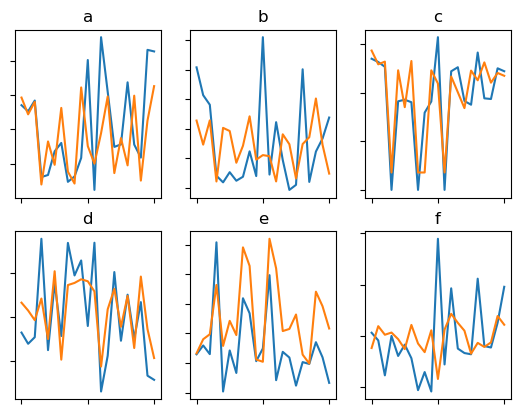

In [45]:

def tree_forecast(train_data, test_data):
    tree_forecast = pd.DataFrame()
    tests = {}
    for col in SERIES_COLS:### Split up the data
        train_features, test_features, train_labels, test_labels = train_test_split(train_data[col],
                                                                                    test_data[col],
                                                                                    test_size = 0.1,
                                                                                    random_state = 5318008)
        model = HistGradientBoostingRegressor(loss = 'squared_error',
                                              random_state = 5318008)
        model.fit(train_features, train_labels)
        outsample_forecast = model.predict(test_features)
        errors = outsample_forecast - test_labels
        forecast = model.predict(train_data[col + "_to_forecast"])
        confidence = np.quantile(errors, [0.1, 0.9])
        tests[col + "_model"] = model
        tests[col + "_errors"] = errors
        tests[col + "_forecast"] = forecast
        tests[col + "_confidence"] = confidence
        tree_forecast[col + "_true"] = test_labels
        tree_forecast[col + "_test"] = outsample_forecast
    return tests, tree_forecast

    
def plot_tree_forecasts(df, axis, x,y, col):
    axis[x,y].plot(df[col + "_true"])
    axis[x,y].plot(df[col + "_test"])
    axis[x, y].set_title(col)
    axis[x,y].xaxis.set_ticklabels([])
    axis[x,y].yaxis.set_ticklabels([])
    return

results, forecasts = tree_forecast(ir_train_data, ir_test_data)
plot_all(forecasts, plot_tree_forecasts)


#### Visually these results look much better than previous results. However, the "confidence intervals" are quite wide.

In [47]:
results

{'a_model': HistGradientBoostingRegressor(random_state=5318008),
 'a_errors': array([  5.55746654,  -2.16140094,  -0.96976847,  -5.41205519,
         24.4327812 ,  -9.86281085,  25.51776324,   7.39717552,
         -5.15599391,  51.34019843, -62.72136693,  19.11746527,
        -69.90183191,  -3.4229883 , -19.07801888,   4.61253774,
        -60.47190034,  35.59639735, -16.71874623, -51.56123159,
        -25.2742436 ]),
 'a_forecast': array([115.980256  , 120.67725487, 143.63511537, 114.91984122,
        128.31743132, 123.72802824, 113.64764938,  87.52276487,
         92.47811433, 116.39038747, 116.06351689, 110.452452  ,
         81.76040295, 105.33403762,  96.23120824,  90.73746479,
         82.27274437,  93.66396774,  97.22173564,  73.37147894,
         84.03970658]),
 'a_confidence': array([-60.47190034,  25.51776324]),
 'b_model': HistGradientBoostingRegressor(random_state=5318008),
 'b_errors': array([-1.80031439, -1.67254087, -0.52785401, -0.19374911,  1.84330946,
         1.393412

In [48]:
for col in SERIES_COLS:
    avg = results[col+"_forecast"].mean()
    print(col + ": " + str(avg))

a: 104.21169327798903
b: 5.809543283837436
c: 22.25170382780174
d: 132.92111646034022
e: 19.697447709925516
f: 5.074322614000824


#### Let's repeat this experiment for squared EOD returns and if we like the results we can try some of the instantaneous returns.

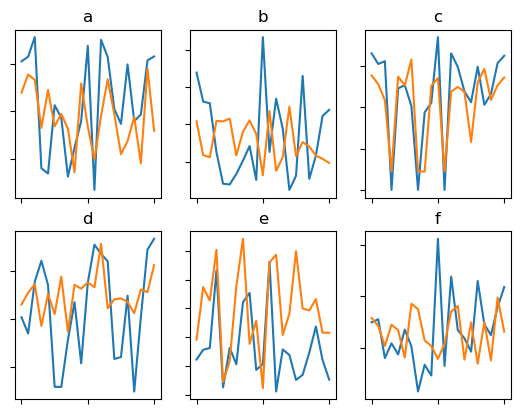

In [49]:
eod_train_data = {}
for col in SERIES_COLS:
    windows = [np.array(window.to_list()) for window in daily_change[col].rolling(window = NUM_DAYS)]
    eod_train_data[col] = np.power(np.array(windows[NUM_DAYS:-NUM_DAYS]), 2)
    eod_train_data[col+"_to_forecast"] = np.power(np.array(windows[-NUM_DAYS:]), 2)
    
### I want to predict the annualized vol for the following month.
def roll_up(arr):
    return np.sqrt(12*np.sum(np.power(arr,2)))

eod_test_data = {}

for col in SERIES_COLS:
    eod_test_data[col] = daily_change[col].rolling(window = NUM_DAYS).apply(roll_up).to_numpy()[2*NUM_DAYS:]

results, forecasts = tree_forecast(eod_train_data, eod_test_data)
plot_all(forecasts, plot_tree_forecasts)

In [50]:
results

{'a_model': HistGradientBoostingRegressor(random_state=5318008),
 'a_errors': array([-13.26782862,  -7.55641123, -18.0886093 ,  17.11212676,
         35.40079757,  -8.87496242,   1.67355473,  20.22278209,
        -10.49389548,  15.96606208, -34.30945714,  12.93582492,
        -32.1690994 ,  -9.45730173,  -2.26293102, -12.83281684,
        -32.52836439,   1.84288437, -20.69128852,  -3.50680127,
        -31.45489263]),
 'a_forecast': array([81.80373401, 81.35465386, 79.42608393, 63.41928272, 79.90905246,
        72.64564539, 69.66904809, 70.81236638, 69.71806771, 74.09299296,
        66.53120382, 67.84902123, 69.22879996, 74.96335153, 90.70045291,
        88.01524015, 77.95457894, 77.83249036, 80.10618651, 67.62879098,
        74.21471403]),
 'a_confidence': array([-32.1690994 ,  17.11212676]),
 'b_model': HistGradientBoostingRegressor(random_state=5318008),
 'b_errors': array([-1.30953793e+00, -1.43743741e+00, -1.44914847e+00,  8.36629827e-01,
         1.67445710e+00,  1.77122776e+00,  

In [51]:
for col in SERIES_COLS:
    avg = results[col+"_forecast"].mean()
    print(col + ": " + str(avg))

a: 75.13694085354739
b: 3.4556540166984413
c: 13.537684499677752
d: 18.13081432939503
e: 12.3088047711488
f: 4.387049815032556
